In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)


# this is the call to be customised to pull different variables out of the CMIP archive
# list of vars: https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271
# list of runs: https://docs.google.com/spreadsheets/d/1SktYsKYhRxQFjUsGYbKxu6G4egpQePbQ1Y5bgERRg3M/edit#gid=1894225558
result = esgf_search(activity_id='ScenarioMIP', table_id='Omon', variable_id='uo', experiment_id='ssp585',
                  institution_id="NCAR", source_id="CESM2")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=uo&experiment_id=ssp585&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Omon&variable_id=uo&experiment_id=ssp585&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10


['http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r10i1p1f1_gn_201501-206412.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r10i1p1f1_gn_206501-210012.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r11i1p1f1_gn_201501-206412.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r11i1p1f1_gn_206501-210012.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r4i1p1f1_gn_201501-206412.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Omon/uo/gn/v20200528/uo_Omo

In [3]:
#ds = xr.open_mfdataset(files_to_open, combine="by_coords")

files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/SImon/siu/gn/v20190313/siu_SImon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc"
dsu = xr.open_dataset(files_to_open)
dsu

files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/SImon/siv/gn/v20190313/siv_SImon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc"
dsv = xr.open_dataset(files_to_open)
dsv

/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siv' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, time: 600, d2: 2, nvertices: 4)
Coordinates:
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 1899-12-15 12:00:00
    lat        (nj, ni) float64 ...
    lon        (nj, ni) float64 ...
Dimensions without coordinates: d2, nvertices
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (nj, ni, nvertices) float32 ...
    lon_bnds   (nj, ni, nvertices) float32 ...
    siv        (time, nj, ni) float32 ...
Attributes: (12/45)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           306600.0
    case_id:                         24
    ...                              ...
    table_id:                        SImon
    tracking_id:                     hdl:21.14100/a15a5429-2902-4ec0-a7a7-15d...
    variable_id:                     siv
    variant_info:                    CMIP6 20th century experiments (1850-201...
    variant_label:                   r10i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

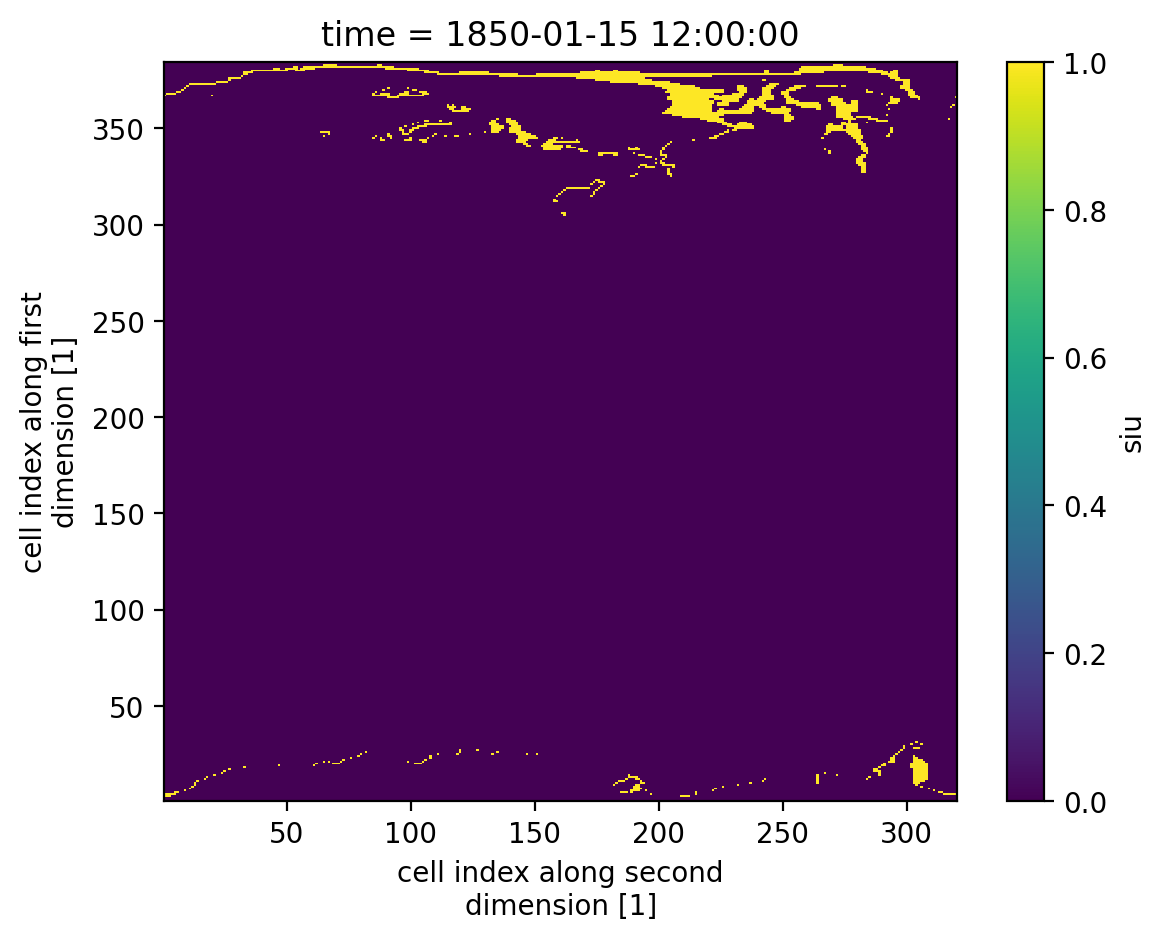

In [4]:
lfsi = 0. * dsu.siu.sel(time=dsu.time[0])
for it in dsu.time:
    lfsi += (np.sqrt(dsu.siu.sel(time=it).squeeze()**2+dsv.siv.sel(time=it)**2) < 0.025)
lfsi /= dsu.time.size
lfsi = (lfsi > 0.5)
lfsi.plot()

In [5]:
files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/SImon/siu/gn/v20190514/siu_SImon_CESM2_historical_r11i1p1f1_gn_200001-201412.nc"
dsu = xr.open_dataset(files_to_open)

files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/SImon/siv/gn/v20190514/siv_SImon_CESM2_historical_r11i1p1f1_gn_200001-201412.nc"
dsv = xr.open_dataset(files_to_open)

/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siv' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


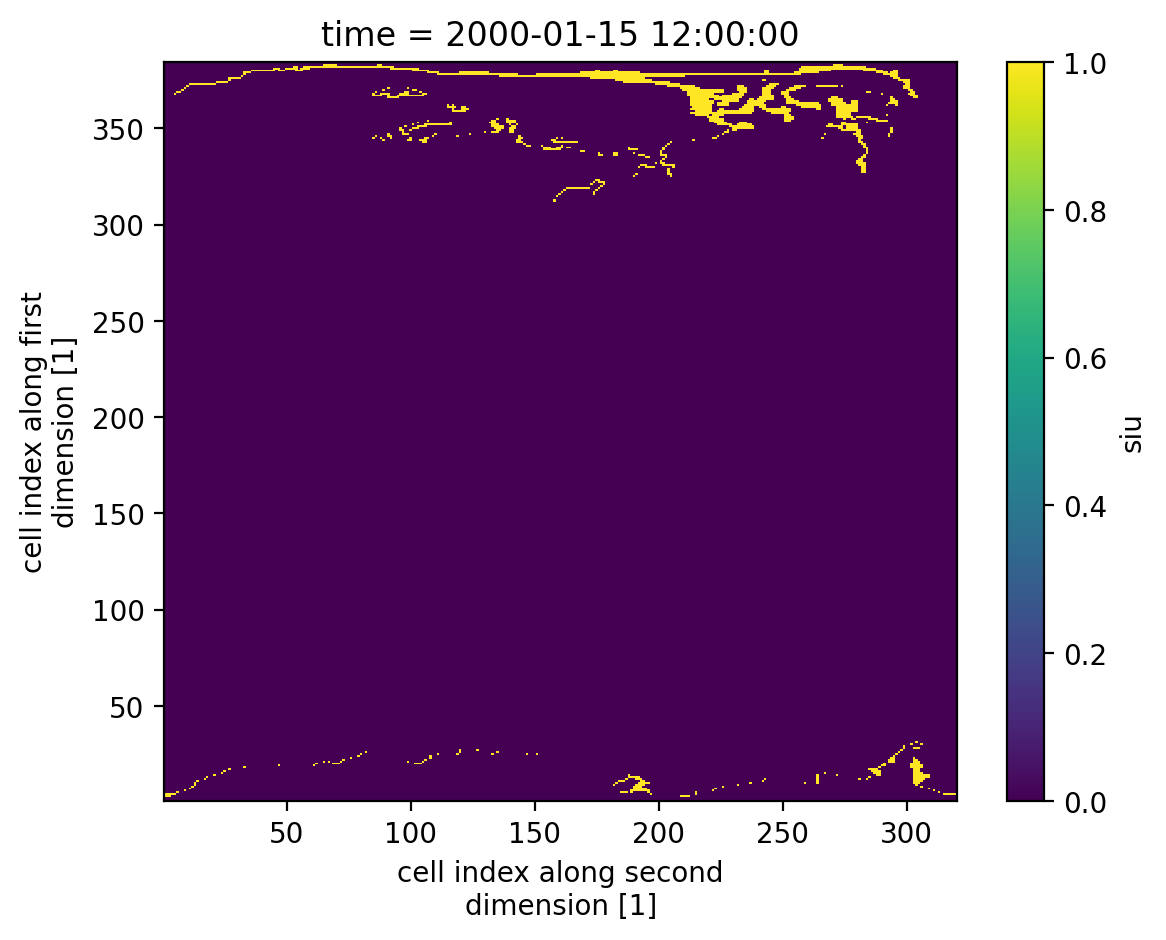

In [6]:
lfsi = 0. * dsu.siu.sel(time=dsu.time[0])
for it in dsu.time:
    lfsi += (np.sqrt(dsu.siu.sel(time=it).squeeze()**2+dsv.siv.sel(time=it)**2) < 0.025)
lfsi /= dsu.time.size
lfsi = (lfsi > 0.5)
lfsi.plot()

In [7]:
files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r2i1p1f1/SImon/siu/gn/v20190730/siu_SImon_CESM2_ssp585_r2i1p1f1_gn_206501-210012.nc"
dsu = xr.open_dataset(files_to_open)

files_to_open = "http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Omon/uo/gn/v20200528/uo_Omon_CESM2_ssp585_r4i1p1f1_gn_206501-210012.nc"
dsuo = xr.open_dataset(files_to_open)

files_to_open = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r2i1p1f1/SImon/siv/gn/v20190730/siv_SImon_CESM2_ssp585_r2i1p1f1_gn_206501-210012.nc"
dsv = xr.open_dataset(files_to_open)

files_to_open = "http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Omon/vo/gn/v20200528/vo_Omon_CESM2_ssp585_r4i1p1f1_gn_206501-210012.nc"
dsvo = xr.open_dataset(files_to_open)
dsvo

/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uo' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siv' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/global/cfs/cdirs/fanssie/users/hoffman2/mambaforge/envs/devalpha6_for_jupyter/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vo'

<xarray.Dataset>
Dimensions:    (lev: 60, nlat: 384, nlon: 320, time: 432, d2: 2, vertices: 4)
Coordinates:
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 2065-01-15 12:00:00 ... 2100-12-15 12:00:00
    lat        (nlat, nlon) float64 ...
    lon        (nlat, nlon) float64 ...
Dimensions without coordinates: d2, vertices
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (nlat, nlon, vertices) float32 ...
    lon_bnds   (nlat, nlon, vertices) float32 ...
    lev_bnds   (lev, d2) float32 ...
    vo         (time, lev, nlat, nlon) float32 ...
Attributes: (12/45)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     ScenarioMIP
    branch_method:                   standard
    branch_time_in_child:            735110.0
    branch_time_in_parent:           735110.0
    case_id:                         1735
    ...                              ...
    table_id:                        Omon
    tracking_id:                     hdl:21.14100/8416256b-be2a-4fc0-9c91-d80...
    variable_id:                     vo
    variant_info:                    CMIP6 SSP5-8.5 experiments (2015-2100) w...
    variant_label:                   r4i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
lfsi = 0. * dsu.siu.sel(time=dsu.time[0])
for it in dsu.time:
   #lfsi += (np.sqrt(dsu.siu.sel(time=it).squeeze()**2+dsv.siv.sel(time=it).squeeze()**2) < 0.025)
   #umagi = np.sqrt(dsu.siu.sel(time=it).squeeze()**2+dsv.siv.sel(time=it).squeeze()**2)
    umago = np.sqrt(dsuo.uo.sel(time=it, lev=dsuo.lev[0]).squeeze()**2+dsvo.vo.sel(time=it, lev=dsvo.lev[0]).squeeze()**2)
   #lfsi += (umagi < 0.25 * umago)
    lfsi = lfsi + umago
lfsi /= dsu.time.size
#lfsi = (lfsi > 0.5)
lfsi.plot()